## Surface and uncertainty maps from final predictions

In [1]:
import os
import functions

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import rasterio

from rasterio.features import shapes
from shapely.geometry import shape, mapping

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

%load_ext autoreload

### Parameters

In [2]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [3]:
country = report['Country']
year = report['DHS survey year']
#target_indicator = report['Target Indicator']
target_indicator = report['Target Indicator']

### Load files

In [4]:
# Load the shape file with geographic covariates
shape_path = os.path.join('temp_files/clipped_shape/clipped_shape.shp')
gdf = gpd.read_file(shape_path)

In [5]:
gdf = gdf[['grid_id', 'geometry']]

In [6]:
#Load report
with open('temp_files/predictions.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

### Revert normalization and transform

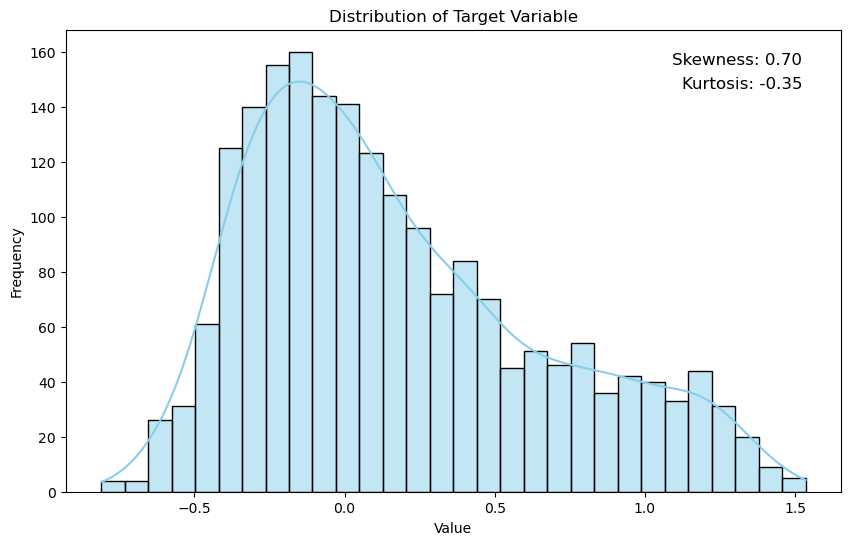

In [7]:
functions.plot_distribution_with_statistics(pd.Series(df[target_indicator]))

#Revert standardization
df[target_indicator+'_denormalized'] = functions.revert_standardization(df[target_indicator], 
                                                                        report['Target mean'], 
                                                                        report['Target std'])

In [8]:
# Load the scaler from the pickle file
with open('scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# Use the inverse_transform method to revert to original values
df[target_indicator+'_denormalized'] = scaler_y.inverse_transform(df[target_indicator].values.reshape(-1, 1)).flatten()

In [9]:
#Revert transformation
df[target_indicator] = functions.revert_transformation(df[target_indicator+'_denormalized'], 
                                report['Transformation Applied'],
                                report['Target mean pre transform'], 
                                report['Target std pre transform'], 
                               report['Lambda']).round(4)

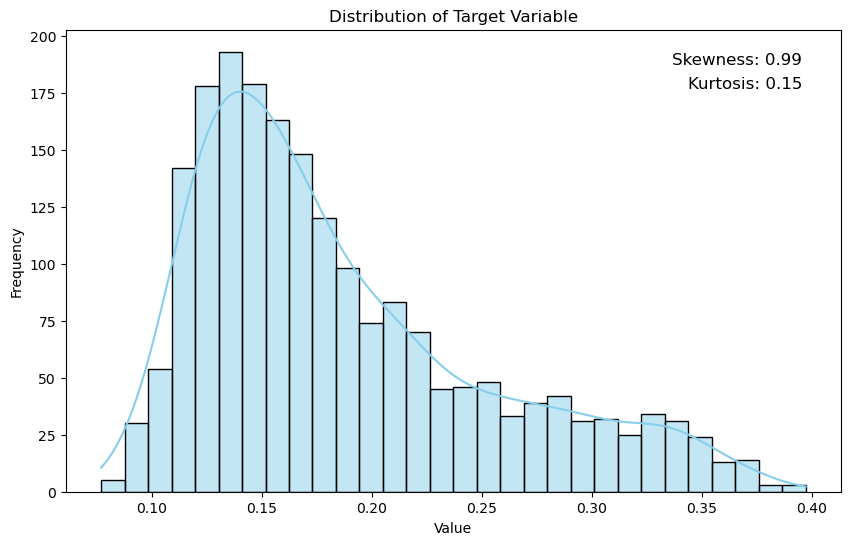

In [10]:
picture_path = os.path.join('temp_files/report', '12. Target Predictions.png')
functions.plot_distribution_with_statistics(pd.Series(df[target_indicator]), picture_path)

### Merge with gdf

In [11]:
gdf = gdf.merge(df[['grid_id', target_indicator, 'ci_lower', 'ci_upper']], how='left', on='grid_id')

### Surface maps

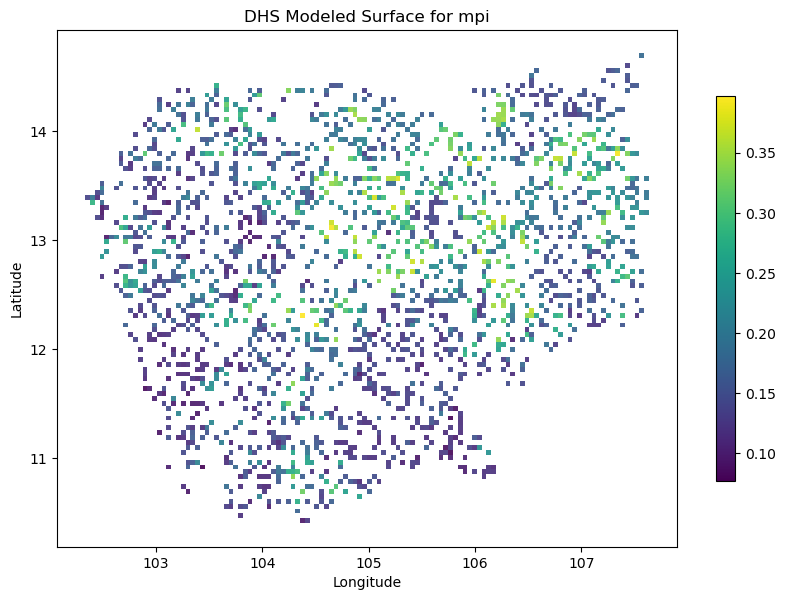

In [12]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a colormap based on the target_indicator
gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.8)

# Customize the plot (optional)
ax.set_title(f'DHS Modeled Surface for {target_indicator}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot again with a legend
gdf_plot = gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.5)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf[target_indicator].min(), vmax=gdf[target_indicator].max()))
sm._A = []  # Create an empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the 'shrink' parameter to reduce color bar size


# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'{country} - {year} -  {target_indicator} Predictions.pdf'))

plt.show()



### Uncertainty Quantification

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

Width of the Confidence Interval (ci_width):

    This represents the range between the upper and lower bounds of the confidence interval.

Absolute Confidence Interval (absolute_confidence_interval):

    This is half the width of the confidence interval. It's the margin of error, representing how far the estimate could be from the true population parameter, in absolute terms.

In [13]:
# Adding a column to represent the absolute confidence interval (absolute margin of error)

gdf['ci_width'] = gdf['ci_upper'] - gdf['ci_lower']
# Adding a column to represent the width of the confidence interval

gdf['absolute_confidence_interval'] = gdf['ci_width'] / 2 #Absolute margin of error

gdf['standardized_uncertainty'] = (gdf['absolute_confidence_interval'] - gdf['absolute_confidence_interval'].mean())  / gdf['absolute_confidence_interval'].std()

### Uncertainty maps

Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

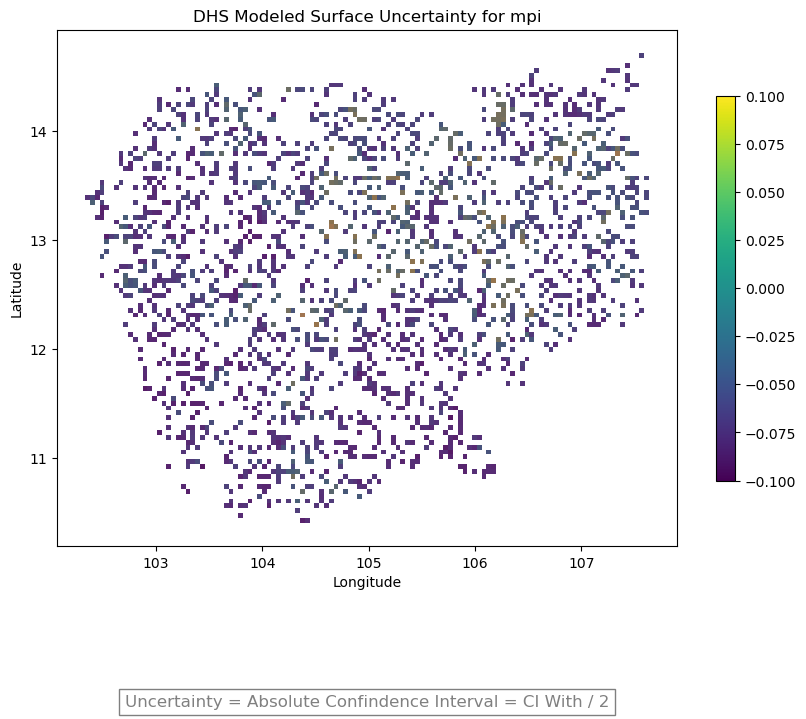

In [14]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a colormap based on the target_indicator
gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.8)

# Customize the plot (optional)
ax.set_title(f'DHS Modeled Surface Uncertainty for {target_indicator}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot again with a legend
gdf_plot = gdf.plot(ax=ax, column='absolute_confidence_interval', cmap='viridis', alpha=0.5)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['absolute_confidence_interval'].min(), vmax=gdf['absolute_confidence_interval'].max()))
sm._A = []  # Create an empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the 'shrink' parameter to reduce color bar size

# Add a note to the plot
note_text = 'Uncertainty = Absolute Confindence Interval = CI Width / 2'

ax.text(0.5, -0.3, note_text, transform=ax.transAxes, fontsize=12, color='gray', 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'{country} - {year} -  {target_indicator} Predictions.pdf'))

plt.show()

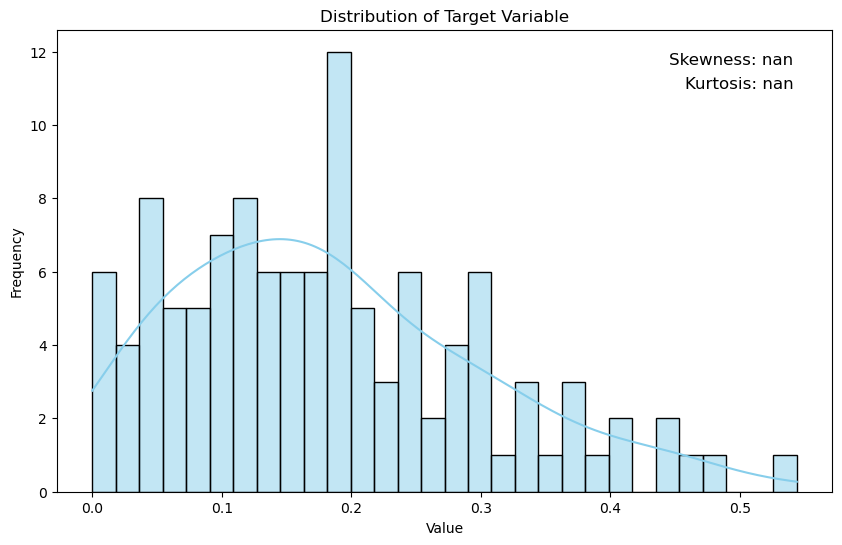

In [15]:
#Comparte to original values
gdf1 = pd.read_pickle('temp_files/selected_features.pkl')

selected_features = gdf1.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

functions.plot_distribution_with_statistics(pd.Series(gdf1[target_indicator]), picture_path)